In [1]:
cd /data/store01/data_dirs/students/ucfafyi/S2_MODIS

/data/store01/data_dirs/students/ucfafyi/S2_MODIS


In [2]:
import sys
sys.path.insert(0,'python')
from Py6S import *
import gp_emulator
import pickle
from functools import partial
import pylab as plt
from scipy.stats import linregress
%matplotlib inline
import numpy as np

In [3]:
S2_RSRs = pickle.load(open('Nov_ipynb/S2_RSRs.pkl', 'r'))

In [21]:
S2_RSRs[0][1:]

(0.44,
 0.53749999999999998,
 array([  1.20588800e-03,   2.68059100e-03,   2.07629200e-03,
          2.50630600e-03,   2.37676100e-03,   2.95953550e-03,
          9.02831100e-03,   6.15215195e-02,   2.92197461e-01,
          3.84103233e-01,   4.00157587e-01,   4.36986335e-01,
          5.05322972e-01,   5.32115365e-01,   5.34655585e-01,
          5.50703997e-01,   6.01967211e-01,   6.17344641e-01,
          5.75862788e-01,   5.44115079e-01,   5.71684349e-01,
          6.53303194e-01,   7.38396013e-01,   7.70845881e-01,
          7.88363273e-01,   8.16581037e-01,   8.44983399e-01,
          8.32954278e-01,   7.86940349e-01,   7.63704882e-01,
          8.10031414e-01,   9.28170369e-01,   1.00000000e+00,
          8.16154090e-01,   2.86992071e-01,   8.39982360e-02,
          2.50795210e-02,   1.83967500e-03,   4.41445000e-04,
          2.21711000e-04]))

In [34]:
path = '/home/ucfafyi/DATA/Downloads/6SV2.1/sixsV2.1'
#sz = np.arcsin(sz)*180/np.pi
#vz = np.arcsin(vz)*180/np.pi
s = SixS(path)
s.geometry.from_time_and_location(45, 54, '11:00', 30,20)

In [55]:
def atm(p, RSR = None):
    #print len(p[0])
    # ele in km
    TOA_ref , aot550, water, ozone, sz , vz, sa, va = p[0]
    
    path = '/home/ucfafyi/DATA/Downloads/6SV2.1/sixsV2.1'
    sz = np.arcsin(sz)*180/np.pi
    vz = np.arcsin(vz)*180/np.pi
    s = SixS(path)
    ss = []
    s = SixS(path)
    s.altitudes.set_target_sea_level()
    s.altitudes.set_sensor_satellite_level()
    s.ground_reflectance = GroundReflectance.HomogeneousLambertian(GroundReflectance.GreenVegetation)
    s.geometry = Geometry.User()
    s.geometry.solar_a = sa
    s.geometry.solar_z = sz
    s.geometry.view_a = va
    s.geometry.view_z = vz
    s.wavelength = Wavelength(RSR[0], RSR[1], RSR[2])
    s.aero_profile = AeroProfile.PredefinedType(AeroProfile.Continental)
    s.aot550 = aot550
    s.atmos_profile = AtmosProfile.UserWaterAndOzone(water, ozone)
    s.atmos_corr = AtmosCorr.AtmosCorrLambertianFromReflectance(TOA_ref)
    s.run()
    return s.outputs.atmos_corrected_reflectance_lambertian

In [56]:
parameters = ['TOA_ref','aot550', 'water', 'ozone', 'sz','vz', 'sa', 'va']
min_vals = [0.,0.,0., 0., 0., 0., 0. , 0.]
max_vals = [1,5,50, 1, 0.99, 0.99, 360, 360]

In [54]:
atm(((1,5,50, 1, 0.99, 0.99), ), RSR=S2_RSRs[0][1:])

3.49298

In [ ]:
n_train =500
n_validate = 50
retval = []
for band in range(7):
    simulator = partial (atm, RSR=S2_RSRs[band][1:])
    x = gp_emulator.create_emulator_validation ( simulator, parameters, min_vals, max_vals, 
                                                n_train, n_validate, do_gradient=True, n_tries=15, n_procs=16)
    retval.append(x)

In [17]:
retval

[(<gp_emulator.GaussianProcess.GaussianProcess instance at 0x7f44f0ce8440>,
  array([[  8.50296614e-01,   1.38804878e+00,   1.13699798e+01,
            2.08313705e-01,   2.67287293e-01,   9.04083032e-01],
         [  3.60451152e-01,   4.13822556e+00,   1.72241470e+01,
            6.83083553e-01,   4.17261359e-01,   3.73116181e-01],
         [  3.93523193e-01,   3.69534528e+00,   3.83667879e+01,
            1.90147590e-01,   6.49329601e-01,   1.18874299e-01],
         [  3.65232098e-01,   1.14961597e+00,   1.08737972e+01,
            5.97702340e-01,   4.80717027e-01,   4.23754157e-01],
         [  3.01046550e-01,   2.02127453e+00,   1.70573583e+01,
            4.05510775e-01,   4.87718517e-01,   7.26624446e-01],
         [  2.87929044e-01,   1.29444608e-01,   1.75351362e+00,
            5.94168549e-02,   4.11174586e-01,   9.50794765e-01],
         [  1.95575076e-01,   7.47347169e-01,   3.79793254e+01,
            4.38365666e-01,   6.03115887e-01,   4.64275446e-01],
         [  9.0135089

1 &  0.942 & -0.105 &  0.674 & 1.489e-01 & 6.900e+00\\
2 &  0.304 & -1.543 &  0.102 & 4.274e-01 & 5.918e+01\\
3 &  0.714 & -0.618 &  0.289 & 3.415e-01 & 1.572e+01\\
4 &  0.401 &  1.291 &  0.160 & 3.573e-01 & 1.721e+01\\
5 &  1.031 & -0.013 &  0.981 & 2.961e-02 & 2.864e-01\\
6 &  1.001 & -0.012 &  0.949 & 4.787e-02 & 8.439e-01\\
7 &  0.896 &  0.218 &  0.494 & 2.274e-01 & 4.111e+00\\


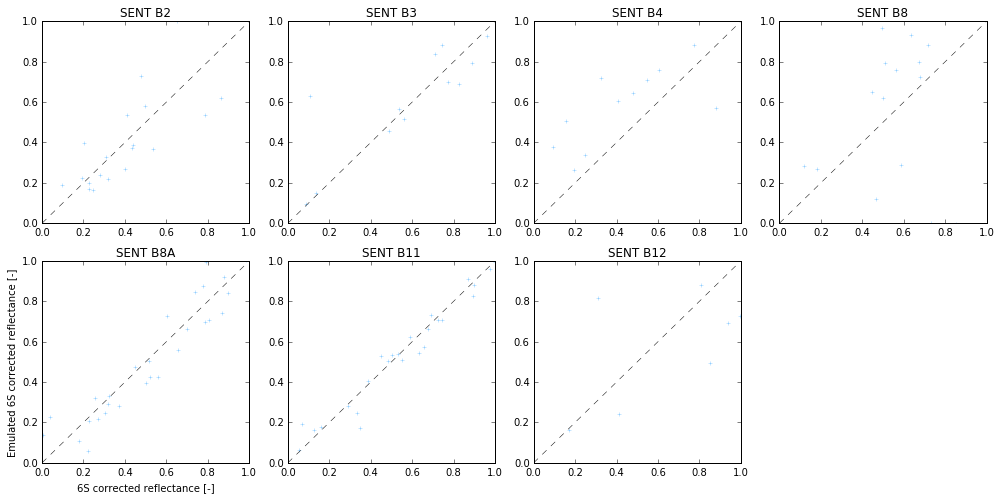

In [18]:
fig1, axs1 = plt.subplots ( nrows=2, ncols=4, figsize=(14,7))
#fig2, axs2 = plt.subplots ( nrows=4, ncols=3, figsize=(9,9))
axs1 = axs1.flatten()
#axs2 = axs2.flatten()
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8A_MB2,SB11_MB6,SB12_MB7').split(',')

for iband in xrange (7):
    gp, validate, validate_output, validate_gradient, emulated_validation, emulated_gradient = retval[iband]

    slope, intercept, r_value, p_value, std_err = linregress( validate_output, emulated_validation.squeeze() )
    axs1[iband].plot ( validate_output, emulated_validation, '+', mec="#90ceff", mfc="none", rasterized=True, markersize= 4 )
    ymax = max(validate_output.max(), emulated_validation.max())
    if iband == 2:
        ymax = ymax*1.7
    axs1[iband].plot ( [0, 1.2*ymax], [0, 1.2*ymax], 'k--', lw=0.5)
    #p = np.polyfit ( validate_output, emulated_validation, 1)
    mae = np.abs(validate_output- emulated_validation.squeeze()).max()
    print "%d & %6.3f & %6.3f & %6.3f & %6.3e & %6.3e\\\\" % (iband+1, slope, intercept, r_value, std_err, mae),
    ymax = 1
    x = np.linspace(0, 1.1/1.2, 5)
    #axs1[iband].plot ( x, np.polyval ( p, x), '-', lw=0.4  )
    axs1[iband].set_ylim ( 0, ymax )
    axs1[iband].set_xlim ( 0, ymax )
    #pretty_axes ( axs1[iband])
    axs1[iband].set_title ('SENT %s'%(names[iband][1:-4]))
    print
axs1[4].set_ylabel ( "Emulated 6S corrected reflectance [-]")
axs1[4].set_xlabel ( "6S corrected reflectance [-]")
plt.tight_layout()     
axs1[7].set_visible (False)